## Import TensorFlow and other libraries

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf

import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import os
import sys
import cv2
from sklearn.model_selection import train_test_split
import tkinter
from tkinter import filedialog
tkinter.Tk().withdraw()
path=filedialog.askdirectory(title='path for whole dataset')
#date="Oct15_Same"
date="July36_Same_Dataset_Balanced"
mask="Dataset1_July36"
csv_path=3
from glob import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

#tf_device='/gpu:0'
path_gen="../"+date+"/Generator"
path_dis="../"+date+"/Discriminator"

2024-07-31 23:18:06.406081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.config.list_physical_devices('GPU')

2024-07-31 23:18:20.550676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-31 23:18:20.577622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-07-31 23:18:20.577642: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-07-31 23:18:20.611686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-07-31 23:18:20.611750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-07-31 23:18:20.624619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 125 #350
IMAGE_SIZE=256

#Image_number=4050

In [5]:
def load_data(path, split=0.05):
    images = sorted(glob(os.path.join(path, "Images/*")))
    masks = sorted(glob(os.path.join(path, "Masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    print(len(images))
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
path

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68/1-image extraction/blue_nuclei/After/Data_Oversampled'

In [7]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)=load_data(path)

3538


In [8]:
len(train_y)

3186

In [9]:
def load_train(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    
    input_image = tf.image.decode_png(image1)
   
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
    
        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
        #input_image,real_image=augment(input_image,real_image)
        real_image = (real_image / 127.5) - 1
        input_image = (input_image / 127.5) - 1
        return input_image, real_image
    else:
        input_image = (input_image / 127.5) - 1
        return input_image

In [10]:
def load_test(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [11]:
def load_valid(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1,channels=3)
    
    if(input_image.shape!=([256,256,3])):
        print(input_image.shape)
        print(256-input_image.shape[0])
        print(256-input_image.shape[1])
        input_image=tf.image.pad_to_bounding_box(input_image,0,0,256,256)
    #input_image=tf.image.resize(input_image, [256, 256],
     #                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
        

        #real_image=tf.image.resize(real_image, [256, 256],
                       #   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

 
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [12]:
len(test_y)

176

In [13]:
import random

def augment(input_image, real_image):
    seed = (1, 2)
    tf.random.set_seed(1234)

    if tf.random.uniform(()) > 0.5:
        # Random brightness
        

        # Random saturation
        input_image = tf.image.stateless_random_saturation(input_image, lower=0, upper=1.5, seed=seed)
        real_image = tf.image.stateless_random_saturation(real_image, lower=0, upper=1.5, seed=seed)

        # Random contrast
        input_image = tf.image.stateless_random_contrast(input_image, lower=0, upper=1.5, seed=seed)
        real_image = tf.image.stateless_random_contrast(real_image, lower=0, upper=1.5, seed=seed)

        input_image = tf.image.adjust_gamma(input_image, gamma= random.uniform(0.5, 2.0))
        real_image = tf.image.adjust_gamma(real_image, gamma= random.uniform(0.5, 2.0))

    
        input_image = tf.clip_by_value(input_image, 0, 255)
        real_image = tf.clip_by_value(real_image, 0, 255)


    return input_image, real_image

In [14]:
import random

def augment(input_image, real_image):
    # Set a seed for reproducibility
    seed = (1, 2)
    tf.random.set_seed(1234)
    
    # Apply random rotation by 90 degrees
    if tf.random.uniform(()) > 0.5:
        num_rotations = random.choice([1, 2, 3])  # Randomly choose 90, 180, or 270 degrees rotation
        input_image = tf.image.rot90(input_image, k=num_rotations)
        real_image = tf.image.rot90(real_image, k=num_rotations)
    
    return input_image, real_image


In [15]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset=train_dataset.map(load_train)
#train_dataset=train_dataset.map(augment)
train_dataset=train_dataset.batch(BATCH_SIZE)
valid_dataset=tf.data.Dataset.from_tensor_slices((valid_x,valid_y))
valid_dataset=valid_dataset.map(load_test)
valid_dataset=valid_dataset.batch(1)
test_dataset=tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_dataset=test_dataset.map(load_test)
test_dataset=test_dataset.batch(1)

2024-07-31 23:18:23.348754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 23:18:23.374105: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699885000 Hz
2024-07-31 23:18:23.375144: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55968e817f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-31 23:18:23.375167: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-31 23:18:23.433895: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55968e88bc90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-3

In [16]:
inp,re=load_train(train_x[10],train_y[10])

2024-07-31 23:18:24.754622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


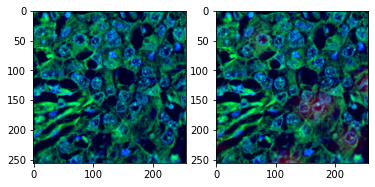

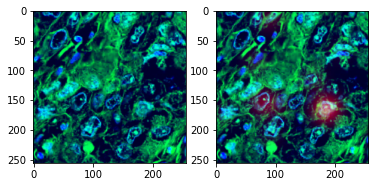

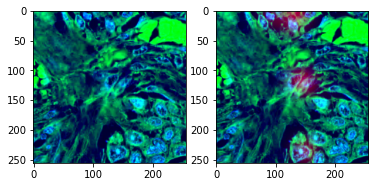

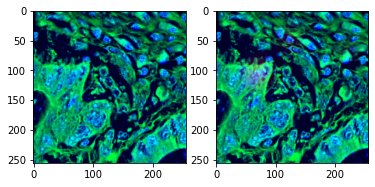

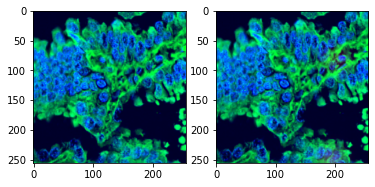

In [17]:
for x,y in train_dataset.take(1):
    #
    # print(x.shape[0])
    for i in range(5):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x[i]*0.5+0.5)
        print(tf.reduce_max(x[i]))
        print(tf.reduce_min(x[i]))
        plt.subplot(1,2,2)
        plt.imshow(y[i]*0.5+0.5)
        print(tf.reduce_max(y[i]))
        print(tf.reduce_min(y[i]))

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [18]:
OUTPUT_CHANNELS = 3

In [19]:
from tensorflow.keras import layers

class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer='ones',
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def cbam_block(input_feature, ratio=8):
    # Channel Attention
    avg_pool = tf.reduce_mean(input_feature, axis=[1, 2], keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)
    
    avg_pool = layers.Dense(input_feature.shape[-1] // ratio, activation='relu')(avg_pool)
    avg_pool = layers.Dense(input_feature.shape[-1])(avg_pool)
    
    max_pool = layers.Dense(input_feature.shape[-1] // ratio, activation='relu')(max_pool)
    max_pool = layers.Dense(input_feature.shape[-1])(max_pool)
    
    channel_attention = layers.Add()([avg_pool, max_pool])
    channel_attention = tf.sigmoid(channel_attention)
    
    # Spatial Attention
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    
    # Combine attentions
    refined_feature = input_feature * channel_attention * spatial_attention
    return layers.Add()([input_feature, refined_feature])

def downsample(filters, size, apply_norm=True, norm_type='batch'):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        if norm_type == 'batch':
            result.add(layers.BatchNormalization())
        elif norm_type == 'instance':
            result.add(InstanceNormalization())
        elif norm_type == 'layer':
            result.add(layers.LayerNormalization())
    result.add(layers.LeakyReLU())
    return result

In [20]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2024-07-31 23:18:28.567476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-07-31 23:18:29.643511: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(1, 128, 128, 3)


In [21]:
def upsample(filters, size, apply_dropout=False, norm_type='batch'):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    if norm_type == 'batch':
        result.add(layers.BatchNormalization())
    elif norm_type == 'instance':
        result.add(InstanceNormalization())
    elif norm_type == 'layer':
        result.add(layers.LayerNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

In [22]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [23]:
from tensorflow.keras.applications import ResNet50

def Generator(norm_type='batch'):
    inputs = layers.Input(shape=[256,256,3])
    
    # Encoder (downsampling)
    e1 = downsample(64, 4, apply_norm=False, norm_type=norm_type)(inputs)
    e1 = cbam_block(e1)
    e2 = downsample(128, 4, norm_type=norm_type)(e1)
    e2 = cbam_block(e2)
    e3 = downsample(256, 4, norm_type=norm_type)(e2)
    e3 = cbam_block(e3)
    e4 = downsample(512, 4, norm_type=norm_type)(e3)
    e4 = cbam_block(e4)
    e5 = downsample(512, 4, norm_type=norm_type)(e4)
    e5 = cbam_block(e5)
    e6 = downsample(512, 4, norm_type=norm_type)(e5)
    e6 = cbam_block(e6)
    e7 = downsample(512, 4, norm_type=norm_type)(e6)
    e7 = cbam_block(e7)
    
    # Bottleneck
    b = downsample(512, 4, norm_type=norm_type)(e7)
    b = cbam_block(b)
    
    # Decoder (upsampling)
    d1 = upsample(512, 4, apply_dropout=True, norm_type=norm_type)(b)
    d1 = layers.Concatenate()([d1, e7])
    d1 = cbam_block(d1)
    
    d2 = upsample(512, 4, apply_dropout=True, norm_type=norm_type)(d1)
    d2 = layers.Concatenate()([d2, e6])
    d2 = cbam_block(d2)
    
    d3 = upsample(512, 4, apply_dropout=True, norm_type=norm_type)(d2)
    d3 = layers.Concatenate()([d3, e5])
    d3 = cbam_block(d3)
    
    d4 = upsample(512, 4, norm_type=norm_type)(d3)
    d4 = layers.Concatenate()([d4, e4])
    d4 = cbam_block(d4)
    
    d5 = upsample(256, 4, norm_type=norm_type)(d4)
    d5 = layers.Concatenate()([d5, e3])
    d5 = cbam_block(d5)
    
    d6 = upsample(128, 4, norm_type=norm_type)(d5)
    d6 = layers.Concatenate()([d6, e2])
    d6 = cbam_block(d6)
    
    d7 = upsample(64, 4, norm_type=norm_type)(d6)
    d7 = layers.Concatenate()([d7, e1])
    d7 = cbam_block(d7)
    
    output = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                    kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                    activation='tanh')(d7)

    return tf.keras.Model(inputs=inputs, outputs=output)

# Create three versions of the generator
generator_batch_norm = Generator('batch')
generator_instance_norm = Generator('instance')
generator_layer_norm = Generator('layer')

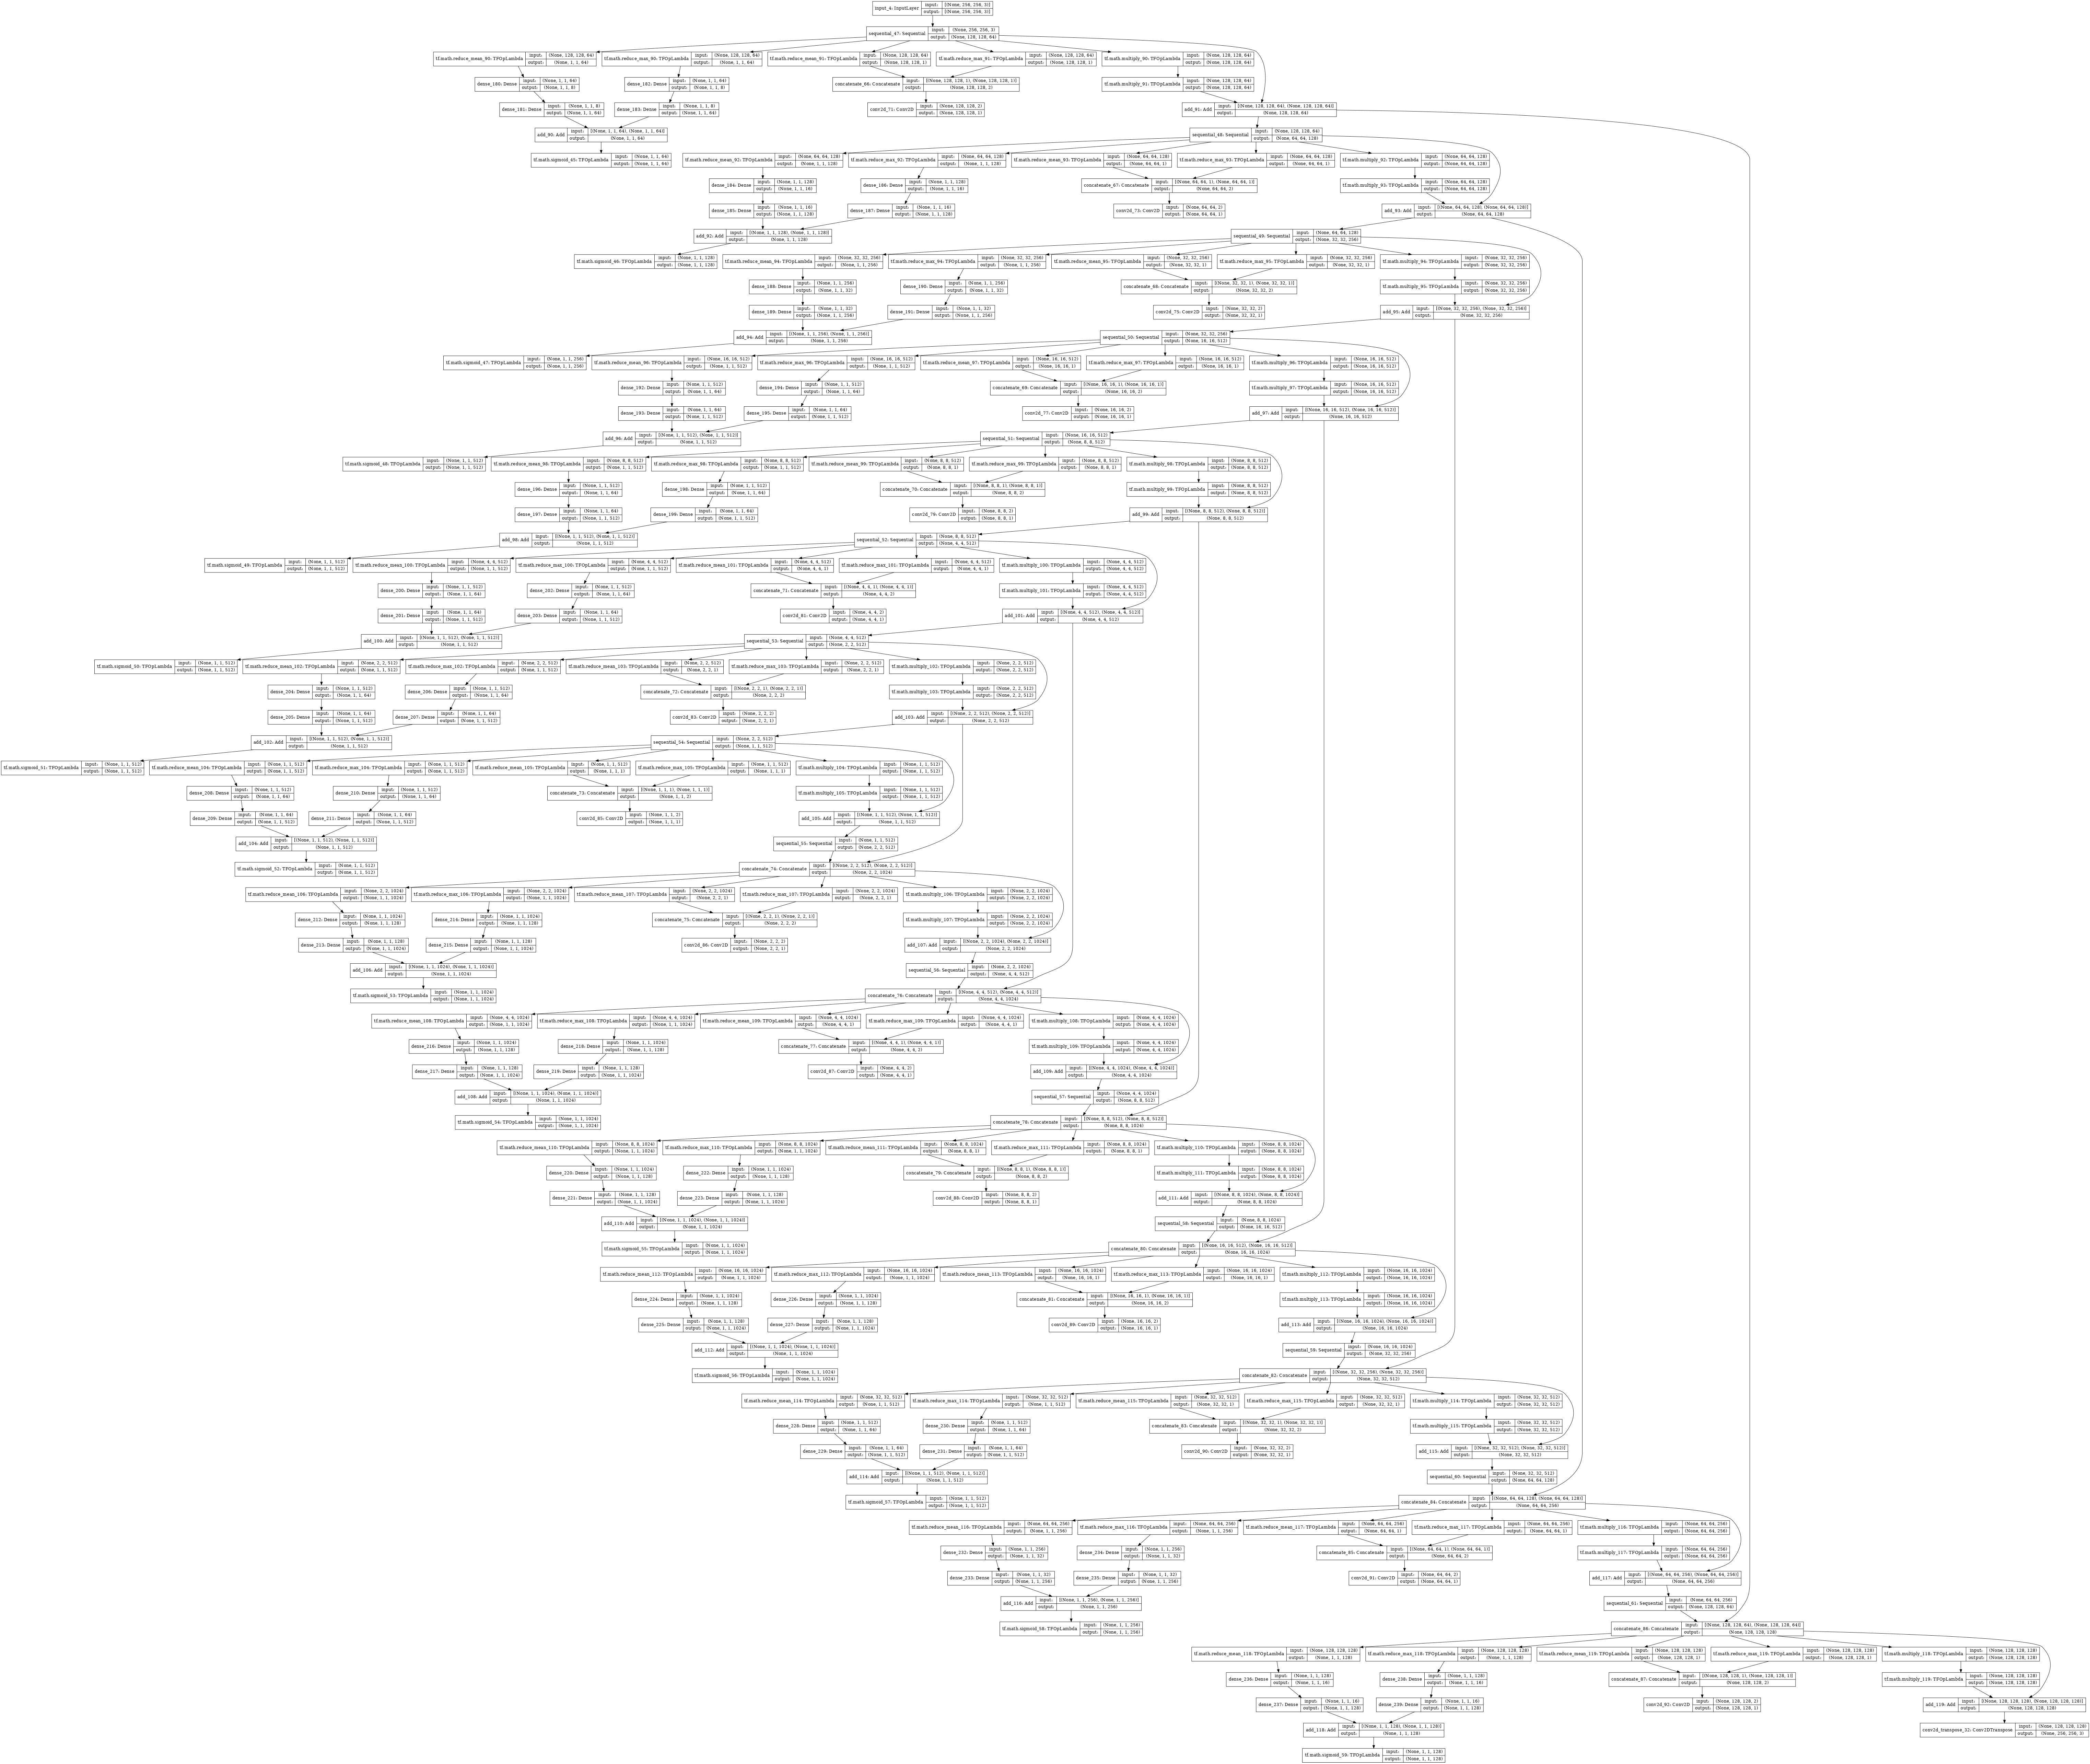

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [25]:
for i, layer in enumerate(generator.layers):
    print(f"{layer.name}, Type: {layer.__class__.__name__}, Output Shape: {layer.output_shape}, Params: {sum(p.size for p in layer.get_weights())}")

input_4, Type: InputLayer, Output Shape: [(None, 256, 256, 3)], Params: 0
sequential_47, Type: Sequential, Output Shape: (None, 128, 128, 64), Params: 3072
tf.math.reduce_mean_90, Type: TFOpLambda, Output Shape: (None, 1, 1, 64), Params: 0
tf.math.reduce_max_90, Type: TFOpLambda, Output Shape: (None, 1, 1, 64), Params: 0
dense_180, Type: Dense, Output Shape: (None, 1, 1, 8), Params: 520
dense_182, Type: Dense, Output Shape: (None, 1, 1, 8), Params: 520
dense_181, Type: Dense, Output Shape: (None, 1, 1, 64), Params: 576
dense_183, Type: Dense, Output Shape: (None, 1, 1, 64), Params: 576
add_90, Type: Add, Output Shape: (None, 1, 1, 64), Params: 0
tf.math.reduce_mean_91, Type: TFOpLambda, Output Shape: (None, 128, 128, 1), Params: 0
tf.math.reduce_max_91, Type: TFOpLambda, Output Shape: (None, 128, 128, 1), Params: 0
tf.math.sigmoid_45, Type: TFOpLambda, Output Shape: (None, 1, 1, 64), Params: 0
concatenate_66, Type: Concatenate, Output Shape: (None, 128, 128, 2), Params: 0
tf.math.multi

In [26]:
import csv

# Assuming 'output.csv' is the desired CSV file
csv_file_path = 'output.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write header to the CSV file
    csv_writer.writerow(['Layer Name', 'Layer Type', 'Output Shape', 'Params'])

    # Assuming generator is your model
    for i, layer in enumerate(generator.layers):
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        output_shape = layer.output_shape
        params = sum(p.size for p in layer.get_weights())

        # Write the information to the CSV file
        csv_writer.writerow([layer_name, layer_type, output_shape, params])

print(f"Data has been generated and saved to {csv_file_path}.")

Data has been generated and saved to output.csv.


In [27]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")


generator.summary(positions = [1, 6, 2, 23], print_fn=custom_print_fn)

In [28]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")

# Assuming you have a model object
model = generator

# Display model summary using the custom print function
model.summary(print_fn=custom_print_fn)


In [29]:
import re
import csv

# Assuming 'input.txt' contains the text with dotted lines
file_path = 'model_summary.txt'

# Read the content of the file
with open(file_path, 'r') as file:
    content = file.read()

# Define a regular expression to capture the content between the dotted lines
pattern = re.compile(r"_+([\w\d\[\]\(\)]+)_+")

# Find all matches in the content
matches = re.findall(pattern, content)

# Write the matches to a CSV file
csv_file_path = 'output.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Layer'])  # Write header

    for match in matches:
        csv_writer.writerow([match])

print(f"Data has been extracted and saved to {csv_file_path}.")


Data has been extracted and saved to output.csv.


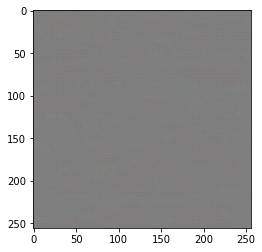

In [30]:
gen_output = generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...]*0.5+0.5)

In [31]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [32]:
def extract_cd3_positive_regions(image, min_red_intensity=-0.9):
    # Assuming 'image' is in the format (height, width, channels) where channels represent RGB

    red_channel = image[:, :, 0]  # Red channel

    # Create a binary mask based on red pixel intensity
    binary_mask = tf.cast(red_channel > min_red_intensity, tf.float32)

    return binary_mask

In [33]:
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + 1e-6)  # Adding a small constant to avoid division by zero

In [34]:
def intersection_over_union(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6) 

In [35]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

In [36]:

def fuzzy_jaccard_loss(y_true, y_pred, tolerance=0.1):
    """
    Calculate the Fuzzy Jaccard Loss for two normalized grayscale images.
    This function is designed to be used as a loss function in TensorFlow models.

    Parameters:
    y_true : Tensor
        Ground truth normalized grayscale image.
    y_pred : Tensor
        Predicted normalized grayscale image.
    tolerance : float
        Maximum difference in intensity values to be considered similar.

    Returns:
    Tensor
        Fuzzy Jaccard Loss (1 - Fuzzy Jaccard Index).
    """
    # Ensure the tensors are of the same shape
    tf.debugging.assert_equal(tf.shape(y_true), tf.shape(y_pred), 
                              message="Inputs must have the same shape")

    # Calculate the similarity matrix
    similarity_matrix = tf.exp(-tf.abs(y_true - y_pred) / tolerance)

    # Calculate the intersection and union
    intersection = tf.reduce_sum(similarity_matrix)
    union = tf.cast(tf.size(y_true), tf.float32)  # Total number of pixels

    # Calculate the Fuzzy Jaccard Index
    fuzzy_jaccard = intersection / union

    # Return the loss (1 - Fuzzy Jaccard Index)
    return 1.0 - fuzzy_jaccard

In [37]:
LAMBDA = 100

In [38]:
def extract_red_channel(image):
    return image[:,:,:,0]  # Assuming the red channel is the first channel

def stain_accuracy_loss(y_true, y_pred):
    # Extract red channels
    y_true_red = extract_red_channel(y_true)
    y_pred_red = extract_red_channel(y_pred)
    
    # Adjust threshold for normalized values (-1 to 1)
    # A value of 0 in the normalized space corresponds to 0.5 in the 0-1 space
    stain_threshold = -0.95
    
    # Create a mask for stained regions
    stain_mask = tf.cast(y_true_red > stain_threshold, tf.float32)
    
    # Calculate loss only in stained regions
    stained_area_loss = tf.reduce_sum(tf.abs(y_true_red - y_pred_red) * stain_mask) / (tf.reduce_sum(stain_mask) + 1e-8)
    
    # Calculate Dice coefficient for stained regions
    # Add 1 to shift the range from [-1, 1] to [0, 2], then divide by 2 to get [0, 1]
    y_true_red_01 = (y_true_red + 1) / 2
    y_pred_red_01 = (y_pred_red + 1) / 2
    
    intersection = tf.reduce_sum(y_true_red_01 * y_pred_red_01 * stain_mask)
    union = tf.reduce_sum(y_true_red_01 * stain_mask) + tf.reduce_sum(y_pred_red_01 * stain_mask)
    dice_loss = 1 - (2 * intersection + 1e-8) / (union + 1e-8)
    
    return stained_area_loss + dice_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # L1 loss on the entire image
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # Stain accuracy loss
    stain_loss = stain_accuracy_loss(target, gen_output)
    
    # You can adjust these weights
    LAMBDA_L1 = 100
    LAMBDA_STAIN = 250  # Higher weight for stain accuracy
    
    total_gen_loss = gan_loss + (LAMBDA_L1 * l1_loss) + (LAMBDA_STAIN * stain_loss)
    
    return total_gen_loss, gan_loss, l1_loss, stain_loss

In [39]:
for x,y in test_dataset.take(20):
    #plt.figure()
    #plt.imshow(y[0]*0.5+0.5)
    #print(intersection_over_union(x[0]*0.5+0.5,x[0]*0.5+0.5))
    #plt.figure()
    a=(extract_cd3_positive_regions(image=y[0],min_red_intensity=-0.7))
    b=(extract_cd3_positive_regions(image=x[0],min_red_intensity=-0.7))
    #plt.imshow(extract_cd3_positive_regions(image=y[0],min_red_intensity=-0.7))
    print(250*(1-dice_coefficient(a,b)))
    #print("mean",tf.reduce_mean((a)))
    #print(a)

tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)
tf.Tensor(250.0, shape=(), dtype=float32)


![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [72]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K

class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, eps=1e-12, training=True, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self.iteration = iteration
        self.eps = eps
        self.do_power_iteration = training

    def build(self, input_shape):
        self.layer.build(input_shape)

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False,
            name='sn_u',
            dtype=tf.float32)

        super(SpectralNormalization, self).build()

    def call(self, inputs, training=None):
        self._normalize_weights()
        output = self.layer(inputs)
        return output

    def _normalize_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u = self.u

        if self.do_power_iteration:
            for _ in range(self.iteration):
                v = tf.math.l2_normalize(tf.matmul(u, w_reshaped, transpose_b=True))
                u = tf.math.l2_normalize(tf.matmul(v, w_reshaped))

            u = tf.stop_gradient(u)
            v = tf.stop_gradient(v)

        sigma = tf.matmul(tf.matmul(v, w_reshaped), u, transpose_b=True)
        self.u.assign(u)
        self.layer.kernel.assign(self.w / sigma)

def ConvSN2D(filters, kernel_size, strides=1, padding='same', activation=None):
    return SpectralNormalization(
        layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, activation=activation, use_bias=False)
    )

# Define Discriminator model (if not already defined)
def Discriminator():
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    
    down1 = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(x)
    down1 = tf.keras.layers.LeakyReLU()(down1)
    
    down2 = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = tf.keras.layers.BatchNormalization()(down2)
    down2 = tf.keras.layers.LeakyReLU()(down2)
    
    down3 = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = tf.keras.layers.BatchNormalization()(down3)
    down3 = tf.keras.layers.LeakyReLU()(down3)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1)(zero_pad2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

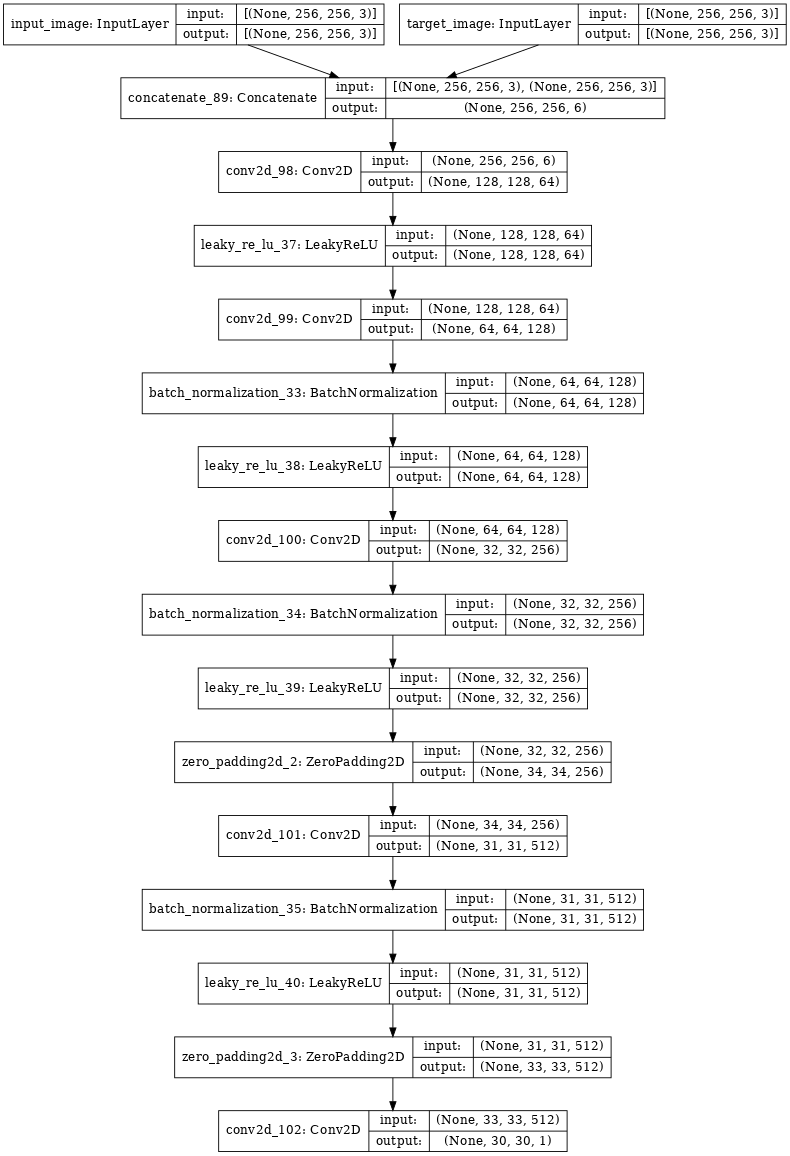

In [73]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [74]:
import csv

# Assuming 'output.csv' is the desired CSV file
csv_file_path = 'output.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write header to the CSV file
    csv_writer.writerow(['Layer Name', 'Layer Type', 'Output Shape', 'Params'])

    # Assuming generator is your model
    for i, layer in enumerate(discriminator.layers):
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        output_shape = layer.output_shape
        params = sum(p.size for p in layer.get_weights())

        # Write the information to the CSV file
        csv_writer.writerow([layer_name, layer_type, output_shape, params])

print(f"Data has been generated and saved to {csv_file_path}.")

Data has been generated and saved to output.csv.


In [75]:
def custom_print_fn(string):
    # Custom printing logic
    with open("model_summary.txt", "a") as f:
        f.write(string + "\n")

# Assuming you have a model object
model = discriminator

# Display model summary using the custom print function
model.summary(print_fn=custom_print_fn)

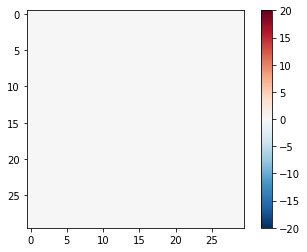

In [76]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [77]:
#1-bce-dice

def loss_object_1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    l=loss_object1(y_true,y_pred)
    return tf.abs(-l+(numerator / denominator))

In [78]:
def dynamic_lambda(i1,i2):
  
    a=tf.equal(i1,i2)
    b=tf.cast(a,tf.float32)
    
    L=LAMBDA/(0.1+tf.reduce_mean(b))
    tf.print(L, output_stream=sys.stderr)
    return L

In [79]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [80]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [81]:
checkpoint_dir = './training_checkpoints/'+date+"/"+mask
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_prefix, max_to_keep=5)

In [82]:
#checkpoint.save(file_prefix = checkpoint_prefix)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [83]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
 
    plt.figure(figsize=(15,15))
    a=extract_cd3_positive_regions(tar[0])
    b=extract_cd3_positive_regions(prediction[0])
    display_list = [test_input[0], tar[0],a, prediction[0],b]
    title = ['Input Image', 'Ground Truth','GT Segmentation', 'Predicted Image','Predict Segmentation']
    print(dice_coefficient(a,b))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    return display_list,title

tf.Tensor(0.0, shape=(), dtype=float32)


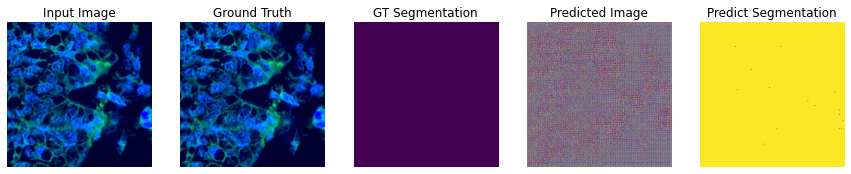

tf.Tensor(0.05968912, shape=(), dtype=float32)


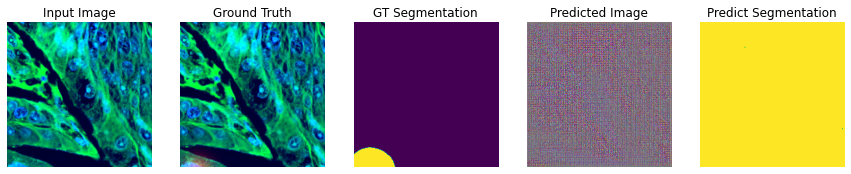

tf.Tensor(0.0, shape=(), dtype=float32)


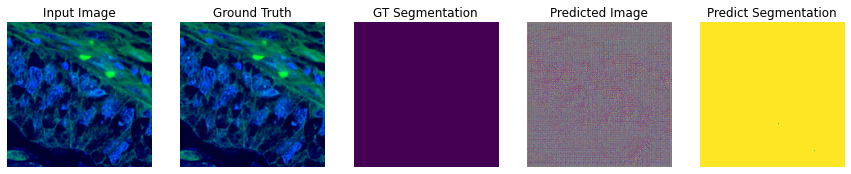

tf.Tensor(0.056148782, shape=(), dtype=float32)


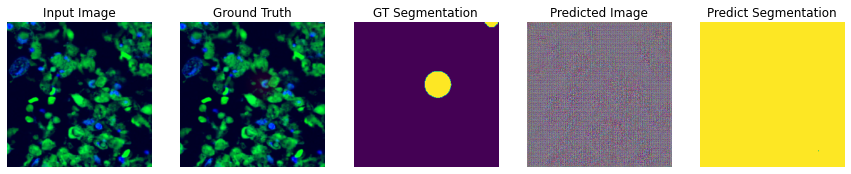

tf.Tensor(0.27358106, shape=(), dtype=float32)


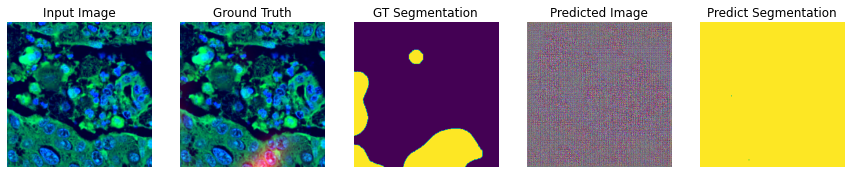

In [84]:
for example_input, example_target in train_dataset.take(5):
    #print("*")
    generate_images(generator, example_input, example_target)

In [85]:
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_47 (Sequential)      (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
tf.math.reduce_mean_90 (TFOpLam (None, 1, 1, 64)     0           sequential_47[0][0]              
__________________________________________________________________________________________________
tf.math.reduce_max_90 (TFOpLamb (None, 1, 1, 64)     0           sequential_47[0][0]              
____________________________________________________________________________________________

In [86]:
discriminator.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_89 (Concatenate)    (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_89[0][0]       

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [87]:
EPOCHS = 150

In [88]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [89]:
disc_loss_1=[]
gen_total_loss_1=[]
gen_l1_loss_1=[]
gen_gan_loss_1=[]
psnr=[]
ssim=[]

In [97]:
@tf.function
def train_step(input_image, target, generator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_stain_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Log metrics
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epochs)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epochs)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epochs)
        tf.summary.scalar('gen_stain_loss', gen_stain_loss, step=epochs)
        tf.summary.scalar('disc_loss', disc_loss, step=epochs)

    return gen_total_loss, disc_loss, gen_gan_loss, gen_l1_loss, gen_stain_loss

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [105]:
import matplotlib.pyplot as plt

def create_red_stain_mask(image, threshold=-0.95):
    # Assuming image is in range [-1, 1]
    red_channel = image[:,:,0]
    return tf.cast(red_channel > threshold, tf.float32)

def visualize_results(generator, input_images, target_images, num_images=5, is_training=True, threshold=-0.95):
    num_images = min(num_images, input_images.shape[0])
    generated_images = generator(input_images, training=False)
    
    plt.figure(figsize=(20, 4*num_images))
    
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 4, 4*i + 1)
        plt.imshow(target_images[i].numpy() * 0.5 + 0.5)
        plt.title(f'{"Training" if is_training else "Validation"} GT')
        plt.axis('off')
        
        # GT Red Stain Mask
        plt.subplot(num_images, 4, 4*i + 2)
        gt_mask = create_red_stain_mask(target_images[i], threshold)
        plt.imshow(gt_mask.numpy(), cmap='gray')
        plt.title(f'{"Training" if is_training else "Validation"} GT Mask')
        plt.axis('off')
        
        # Generated Image
        plt.subplot(num_images, 4, 4*i + 3)
        plt.imshow(generated_images[i].numpy() * 0.5 + 0.5)
        plt.title(f'{"Training" if is_training else "Validation"} Generated')
        plt.axis('off')
        
        # Generated Red Stain Mask
        plt.subplot(num_images, 4, 4*i + 4)
        gen_mask = create_red_stain_mask(generated_images[i], threshold)
        plt.imshow(gen_mask.numpy(), cmap='gray')
        plt.title(f'{"Training" if is_training else "Validation"} Gen Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def fit(train_ds, epochs, test_ds, threshold=-0.95):
    train_iter = iter(train_ds.repeat())
    val_iter = iter(test_ds.repeat())

    for norm_type, generator in [('Batch', generator_batch_norm), 
                                 ('Instance', generator_instance_norm), 
                                 ('Layer', generator_layer_norm)]:
        print(f"\nTraining with {norm_type} Normalization")
        
        for epoch in range(epochs):
            start = time.time()
            
            # Initialize metrics for this epoch
            gen_total_loss_avg = tf.keras.metrics.Mean()
            disc_loss_avg = tf.keras.metrics.Mean()
            gen_gan_loss_avg = tf.keras.metrics.Mean()
            gen_l1_loss_avg = tf.keras.metrics.Mean()
            gen_stain_loss_avg = tf.keras.metrics.Mean()
            
            # Training loop
            for n, (input_image, target) in train_ds.enumerate():
                print('.', end='')
                gen_total_loss, disc_loss, gen_gan_loss, gen_l1_loss, gen_stain_loss = train_step(input_image, target, generator)
                
                # Update metrics
                gen_total_loss_avg.update_state(gen_total_loss)
                disc_loss_avg.update_state(disc_loss)
                gen_gan_loss_avg.update_state(gen_gan_loss)
                gen_l1_loss_avg.update_state(gen_l1_loss)
                gen_stain_loss_avg.update_state(gen_stain_loss)
            
            print()
            print(f'Epoch {epoch+1}/{epochs}')
            print(f'Generator Total Loss: {gen_total_loss_avg.result():.4f}')
            print(f'Discriminator Loss: {disc_loss_avg.result():.4f}')
            print(f'Generator GAN Loss: {gen_gan_loss_avg.result():.4f}')
            print(f'Generator L1 Loss: {gen_l1_loss_avg.result():.4f}')
            print(f'Generator Stain Loss: {gen_stain_loss_avg.result():.4f}')
            
            # Visualize 5 training images
            train_samples = next(train_iter)
            visualize_results(generator, train_samples[0][:5], train_samples[1][:5], num_images=5, is_training=True, threshold=threshold)
            
            # Visualize 5 validation images
            val_samples = next(val_iter)
            visualize_results(generator, val_samples[0][:5], val_samples[1][:5], num_images=5, is_training=False, threshold=threshold)
            
            print(f'Time taken for epoch {epoch + 1} is {time.time()-start} sec\n')

        # Save the model after training
        generator.save(f'generator_{norm_type.lower()}_norm.h5')

# Usage
threshold = -0.95

In [106]:
checkpoint_dir

'./training_checkpoints/July36_Same_Dataset_Balanced/Dataset1_July36'

In [107]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix))
#generator.load_weights(path_gen)
#discriminator.load_weights(path_dis)

tf.Tensor(0.0, shape=(), dtype=float32)


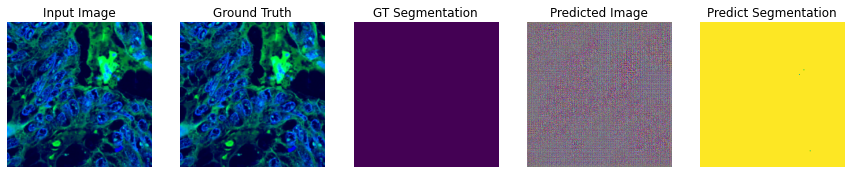

tf.Tensor(0.050481163, shape=(), dtype=float32)


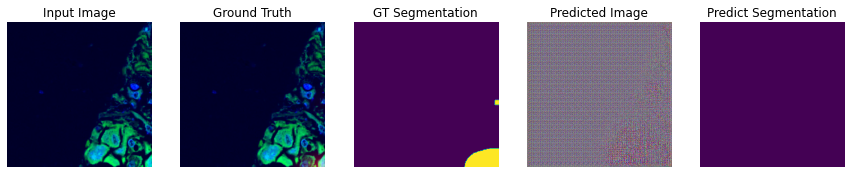

tf.Tensor(0.0, shape=(), dtype=float32)


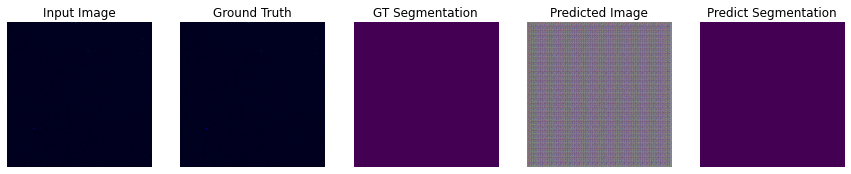

tf.Tensor(0.16440006, shape=(), dtype=float32)


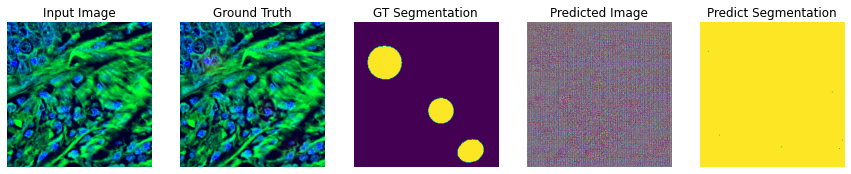

tf.Tensor(0.21589392, shape=(), dtype=float32)


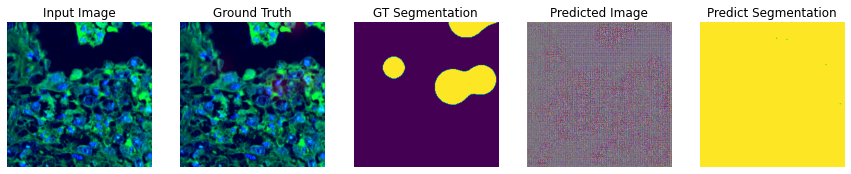

tf.Tensor(0.02137552, shape=(), dtype=float32)


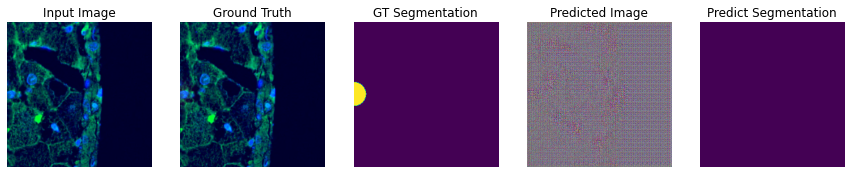

tf.Tensor(0.170208, shape=(), dtype=float32)


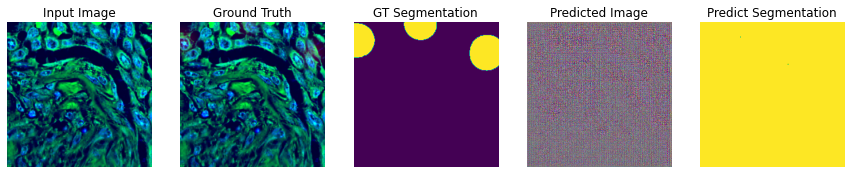

tf.Tensor(0.039106563, shape=(), dtype=float32)


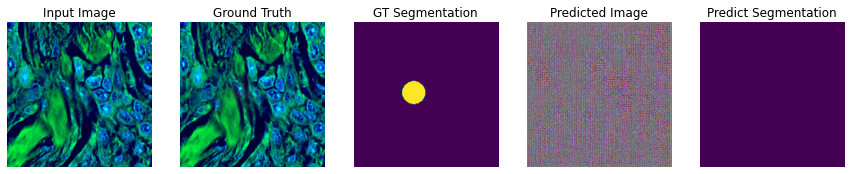

tf.Tensor(0.0, shape=(), dtype=float32)


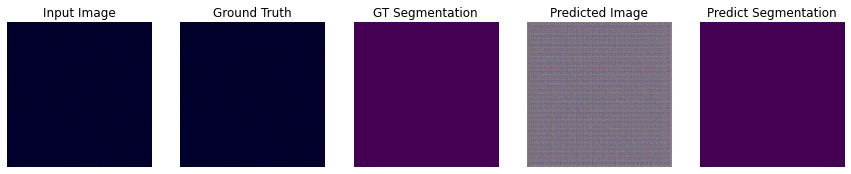

tf.Tensor(0.0029560104, shape=(), dtype=float32)


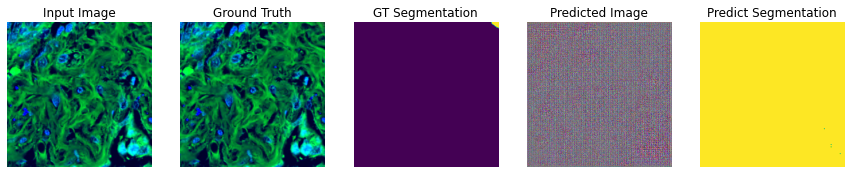

In [108]:
for example_input, example_target in train_dataset.take(10):
            generate_images(generator, example_input, example_target)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [109]:
#docs_infra: no_execute
#!kill 1787
%load_ext tensorboard
%tensorboard --logdir {log_dir}  
#%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 42140), started 0:08:43 ago. (Use '!kill 42140' to kill it.)

Now run the training loop:

In [110]:
fit(train_dataset, int(EPOCHS), valid_dataset, threshold=threshold)


Training with Batch Normalization
.

NameError: in user code:

    /tmp/ipykernel_41531/4073881326.py:20 train_step  *
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epochs)

    NameError: name 'epochs' is not defined


Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## CSV files to get shuffled patch indices (Running once is sufficient)

In [98]:
lst_sort=[]
images = sorted(glob(os.path.join(path, "Images/*")))
for x,y in zip(train_x,images):
    lst_sort.append([x.split("/")[-1],y.split("/")[-1]])

In [99]:
import pandas as pd
df_lst=pd.DataFrame(lst_sort)

In [100]:
# Get shuffled patch indices
df_lst.to_csv("/home/saab/Desktop/file_paths_July9_2024.csv")

In [101]:
lst_sort2=[]
for x in(test_x):
    lst_sort2.append([x.split("/")[-1]])
for x in(valid_x):
    lst_sort2.append([x.split("/")[-1]])
df_lst=pd.DataFrame(lst_sort2)
df_lst.to_csv("/home/saab/Desktop/file_paths_test_July9_2024.csv")

# Asking paths

In [102]:
p_train=filedialog.askdirectory(title='path for train_results') #PredictedCD3Regions folder
p_test=filedialog.askdirectory(title='path for test_results')

In [103]:
p_train

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Raw_Data/CD68/1-image extraction/blue_nuclei/After/Data_Oversampled/Train'

# Training dataset inference

In [104]:

P_train_gt=os.path.join(p_train,"gt")
P_train_pred=os.path.join(p_train,"pred")
P_train_img=os.path.join(p_train,"img")
os.makedirs(P_train_img,exist_ok=True)
os.makedirs(P_train_gt,exist_ok=True)
os.makedirs(P_train_pred,exist_ok=True)
i=0
for x,y in train_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_train_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_train_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_train_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

# Testing dataset inference

In [105]:

P_test_gt=os.path.join(p_test,"gt")
P_test_pred=os.path.join(p_test,"pred")
P_test_img=os.path.join(p_test,"img")
os.makedirs(P_test_img,exist_ok=True)
os.makedirs(P_test_pred,exist_ok=True)
os.makedirs(P_test_gt,exist_ok=True)
i=0
for x,y in test_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        #plt.figure()
        #plt.imshow(img1.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1
for x,y in valid_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 27

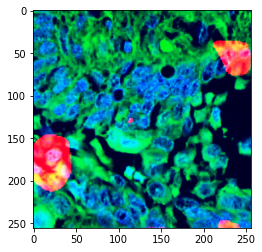

In [106]:
plt.imshow(img1.numpy())

In [ ]:
path_onco_sg=filedialog.askdirectory(title="onco_sg_images")
#date="13thOct"

files_onco_sg=[x for x in sorted(glob(path_onco_sg+"/*/*20x*.jpg"))]
st=set(([x.split("/")[len(x.split("/"))-2] for x in files_onco_sg]))
st=sorted(list(st))
len(st)

204

In [ ]:
st

['A006',
 'A008',
 'A012',
 'A015',
 'A016',
 'A017',
 'A021',
 'A025',
 'A027',
 'A028',
 'A033',
 'A037',
 'A062',
 'A063',
 'A066',
 'A068',
 'A071',
 'A072',
 'A073',
 'A074',
 'A100',
 'A101',
 'A102',
 'A103',
 'A104',
 'A109',
 'A110',
 'A111',
 'A112',
 'A114',
 'A117',
 'A120',
 'A122',
 'A124',
 'A126',
 'A130',
 'A131',
 'A134',
 'A136',
 'A138',
 'A139',
 'A143',
 'A144',
 'A146',
 'A147',
 'A148',
 'A149',
 'A150',
 'A152',
 'A153',
 'A155',
 'A156',
 'A157',
 'A158',
 'A159',
 'A162',
 'A163',
 'A165',
 'A167',
 'A168',
 'A169',
 'A177',
 'A182',
 'A183',
 'A184',
 'A185',
 'A186',
 'A187',
 'A188',
 'A190',
 'A191',
 'A192',
 'A193',
 'A194',
 'A195',
 'A196',
 'A197',
 'A198',
 'A199',
 'A200',
 'A201',
 'A202',
 'A204',
 'A205',
 'A206',
 'A207',
 'A208',
 'A209',
 'A210',
 'A211',
 'A212',
 'A213',
 'A214',
 'A215',
 'A216',
 'A217',
 'A218',
 'A219',
 'A220',
 'A221',
 'A222',
 'A228',
 'A229',
 'A230',
 'A232',
 'A233',
 'A234',
 'A239',
 'A240',
 'A241',
 'A243',
 

In [ ]:
path_predict_onco_sg=filedialog.askdirectory(title="predict_onco_sg_images")


In [ ]:
path_predict_onco_sg

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled'

In [ ]:

for x in st:
    os.makedirs(path_predict_onco_sg+"/"+x,exist_ok=True)
    y=sorted(glob(path_onco_sg+"/"+x+"/*20x*.jpg"))
    
    for z in y:
        fpath=path_predict_onco_sg+"/"+x+"/"+z.split("/")[-1]
        os.makedirs(fpath,exist_ok=True)
        spath=path_onco_sg+"/"+x+"/"+z.split("/")[-1]
        imgs_onco_sg=(sorted(glob(spath+"/*")))
        print(fpath)
        k=1
        for i in imgs_onco_sg:
            a=load_test(i,condtn=False)
            v=generator(np.expand_dims(a,axis=0))
            img=v[0]*0.5+0.5

            plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
            k=k+1
        

/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A006/A006, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A008/A008, paillary, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A012/A012, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A015/A015, acinar, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/A016/A016, solid, 20x.jpg
/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/onco_sg_trial/22_May_2024/Serial/Tiled/

In [71]:
path_val=filedialog.askdirectory(title="validation_images")
#date="13thOct"

files_val=[x for x in sorted(glob(path_val+"/*"))]
st=set(([x.split("/")[-1] for x in files_val]))
st=sorted(list(st))
st

['000.png',
 '001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '007.png',
 '008.png',
 '009.png',
 '010.png',
 '011.png',
 '012.png',
 '013.png',
 '014.png',
 '015.png',
 '016.png',
 '017.png',
 '018.png',
 '019.png',
 '020.png',
 '021.png',
 '022.png',
 '023.png',
 '024.png',
 '025.png',
 '026.png',
 '027.png',
 '028.png',
 '029.png',
 '030.png',
 '031.png',
 '032.png',
 '033.png',
 '034.png',
 '035.png',
 '036.png',
 '037.png',
 '038.png',
 '039.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '046.png',
 '047.png']

In [72]:
path_predict_val=filedialog.askdirectory(title="predict_validation_images")

In [76]:


for x in st:
    fpath=path_predict_val+"/"+x
    os.makedirs(fpath,exist_ok=True)
    y=sorted(glob(path_val+"/"+x+"/*"))
    #print(fpath)
    k=1
    print(len(y))
    for z in y:
        
        #print(z)
        
        a=load_valid(z,condtn=False)
        
    

        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5

        plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
           

        k=k+1    
        

420
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16


(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(256, 240, 3)
0
16
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 256, 3)
184
0
(72, 240, 3)
184
16
441
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105, 3)
0
151
(256, 105

# Extra code

In [ ]:
#!pip install pandas
import pandas as pd



In [ ]:
images = sorted(glob(os.path.join(path, "images/*")))
masks = sorted(glob(os.path.join(path, "masks/*")))


In [ ]:
green = np.zeros([256,256,3],dtype=np.float32)
green[:]=(0,225,0)
green=green/127.5-1

In [ ]:
ind_ssim=[]
numbers=[]
for i in range(len(images)):
    print(i)
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    ss=tf.reduce_mean(tf.image.ssim(v,np.expand_dims(b,axis=0), 1.0))
    #gre=tf.reduce_mean(tf.math.sqrt(tf.abs(tf.math.square(green)-tf.math.square(v[0]))))
    img=v[0]*0.5+0.5
    plt.imshow(img.numpy())
    #tf.print(gre)
    
    ind_ssim.append((ss.numpy(),i))

    #img=np.asarray(v[0]*0.5+0.5,np.uint8)

In [ ]:
ind_ssim.sort()

In [ ]:
max(ind_ssim)

In [ ]:
ssim3=[]
for x in ind_ssim:
    ssim3.append(x[1])

In [ ]:

df_ssim_3=pd.DataFrame({"old_numbers":ssim3})

In [ ]:
df_ssim_3

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:

df_ssim_3=pd.read_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")
path_to_store=os.getcwd()+"/ans_cd3_new/"+date+"/"+mask+"/"
p1=os.path.join(path_to_store,"sorted")
p2=os.path.join(path_to_store,"unsorted")
p3=os.path.join(path_to_store,"sorted_gt")
p4=os.path.join(path_to_store,"unsorted_gt")
os.makedirs(p1,exist_ok=True)
os.makedirs(p2,exist_ok=True)
os.makedirs(p3,exist_ok=True)
os.makedirs(p4,exist_ok=True)

In [ ]:
ssim3=df_ssim_3["old_numbers"].tolist()

In [ ]:
ssim3

In [ ]:
x=0
for i in (ssim3):
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    img2=b*0.5+0.5
    #plt.figure()
    #plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    
    plt.imsave(p1+"/"+f"{x:06d}"+".png",img.numpy())
    plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    plt.imsave(p3+"/"+f"{x:06d}"+".png",img2.numpy())
    plt.imsave(p4+"/"+f"{i:06d}"+".png",img2.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
b_test=glob(os.getcwd()+"/gt/*.png")
p099=os.getcwd()+"/new_test_dataset_results"+date
os.makedirs(p099,exist_ok=True)
x=0
for i in (b_test):
    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    #img2=b*0.5+0.5
    plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    plt.imsave(p099+"/"+f"{x:06d}"+".png",img.numpy())
    #plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [ ]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [ ]:
os.getcwd()+"/old_nos_new_test"+date+".csv"

In [ ]:
new_test_path="/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles"
test_imgs_cptac=sorted(glob(new_test_path+"/*.png"))
len(test_imgs_cptac)

In [ ]:
x=0
test_predict=sorted(glob("/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/*"))
test_predict

In [ ]:
tpi=os.getcwd()+"/predict_hcc1_2"
os.makedirs(tpi,exist_ok=True)
for i in test_predict:

    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5

    plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())

    print(x,end=" ")
    x=x+1

In [ ]:
for tp in test_predict:
    x=0
    tpi=tp+"/predict"
    os.makedirs(tpi,exist_ok=True)
    test_imgs_cptac=sorted(glob(tp+"/small_tiles/*"))
    for i in (test_imgs_cptac):
        a=load(i,condtn=False)
        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5
    
        plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())
    
        print(x,end=" ")
        x=x+1
    print(" ")

In [ ]:
test_y

In [ ]:
p1=filedialog.askdirectory(title='path for unsorted_gt')
print(len(glob(p1+"/*.png")))
p2=filedialog.askdirectory(title='path for unsorted_pred')
print(len(glob(p2+"/*.png")))

In [ ]:
for x in test_y:
    os.remove(p1+"/"+x.split("/")[-1])
    os.remove(p2+"/"+x.split("/")[-1])

In [ ]:
print(len(glob(p1+"/*.png")))
print(len(glob(p2+"/*.png")))

In [57]:
path

'/media/saab/f7ee81f1-4052-4c44-b470-0a4a650ee479/SGH_IMCB_NTU_Main/Processed_Data/Preprocessed_Data/Serial_Slide/15thOct/Dataset1_Oversampled/Dataset'